<b><font size="+2">Libraries</font></b>

In [1]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import sklearn

import tensorflow as tf
from tensorflow import keras

from keras.datasets import fashion_mnist, cifar10, imdb

from sklearn.model_selection import train_test_split

# import layers and callbacks we may use (may not be a complete list)
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Model, Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.applications import MobileNetV2
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.python.keras.utils import layer_utils

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

# Load the TensorBoard notebook extension
#%load_ext tensorboard


# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

def var_exists(var_name):
    return (var_name in globals() or var_name in locals())

------------
### Python version: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
### NumPy version: 1.26.4
### Scikit-learn version: 1.4.2
### Tensorflow version: 2.16.1
------------


<b><font size="+2">Read Data</font></b>

In [2]:
# Define the directory containing the data
data_dir = 'Corn (Maize)'

# Define the categories (folder names)
categories = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

# Initialize lists to store filenames and labels
train_filenames = []
val_filenames = []
train_labels = []
val_labels = []

# Load training data
for category_id, category in enumerate(categories):
    train_category_dir = os.path.join(data_dir, 'Train', category)
    for filename in os.listdir(train_category_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Assuming images are jpg or png format
            train_filenames.append(os.path.join(train_category_dir, filename))
            train_labels.append(category_id)

# Load validation data
for category_id, category in enumerate(categories):
    val_category_dir = os.path.join(data_dir, 'Val', category)
    for filename in os.listdir(val_category_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Assuming images are jpg or png format
            val_filenames.append(os.path.join(val_category_dir, filename))
            val_labels.append(category_id)

# Convert integer labels to one-hot encoded vectors
num_classes = len(categories)
y_train = to_categorical(train_labels, num_classes=num_classes)
y_val = to_categorical(val_labels, num_classes=num_classes)

# Define a function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load image from file
    img = load_img(image_path, target_size=(224, 224))
    # Convert image to numpy array
    img_array = img_to_array(img)
    # Preprocess the image (e.g., normalization)
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Load and preprocess training images
X_train = np.array([load_and_preprocess_image(filename) for filename in train_filenames])

# Load and preprocess validation images
X_val = np.array([load_and_preprocess_image(filename) for filename in val_filenames])

# Check the shapes of the training and validation data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)


Shape of X_train: (2279, 224, 224, 3)
Shape of y_train: (2279, 4)
Shape of X_val: (503, 224, 224, 3)
Shape of y_val: (503, 4)


<b><font size="+2">CNN Model</font></b>

In [3]:
def create_compile_cnn(input_shape=[224, 224, 3], num_outputs=4, verbose=False):
    cnn_model = Sequential(name='CNN')
    
    cnn_model.add(Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv1'))
    cnn_model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv2'))
    cnn_model.add(MaxPooling2D((2, 2), name='MaxPool1'))
    
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv3'))
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv4'))
    cnn_model.add(MaxPooling2D((2, 2), name='MaxPool2'))
    
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv5'))
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                     padding='same', strides=(1, 1), kernel_initializer='lecun_uniform', name='conv6'))
    cnn_model.add(MaxPooling2D((2, 2), name='MaxPool3'))
    
    cnn_model.add(Flatten(name='flatten'))
    
    cnn_model.add(Dense(64, activation='relu', kernel_initializer='lecun_uniform', name='dense1'))
    cnn_model.add(Dropout(0.25, name='drop1'))
    
    cnn_model.add(Dense(32, activation='relu', kernel_initializer='lecun_uniform', name='dense2'))
    cnn_model.add(Dropout(0.25, name='drop2'))
    
    cnn_model.add(Dense(num_outputs, activation='softmax', name='output'))
    
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    if verbose:
        cnn_model.summary()
    
    cnn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return cnn_model

<b><font size="+2">Compile CNN</font></b>

In [4]:
cnn_model = create_compile_cnn(verbose=True)

c:\Users\yashh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool1 (MaxPooling2D)         │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2 (MaxPooling2D)         │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool3 (MaxPooling2D)         │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,285,620 (12.53 MB)

 Trainable params: 3,285,620 (12.53 MB)

 Non-trainable params: 0 (0.00 B)

<b><font size="+2">Fit Model</font></b>

In [5]:
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
max_epochs = 15
batch_size = 64
    
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=max_epochs, batch_size=batch_size, 
                         shuffle=True, callbacks=[early_stop_cb])

# Save the model
cnn_model.save('cnn.keras')

Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 373ms/step - accuracy: 0.7910 - loss: 0.7548 - val_accuracy: 0.8648 - val_loss: 0.3075
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.8916 - loss: 0.2445 - val_accuracy: 0.9165 - val_loss: 0.1323
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.9003 - loss: 0.1890 - val_accuracy: 0.9483 - val_loss: 0.1286
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 354ms/step - accuracy: 0.9344 - loss: 0.1793 - val_accuracy: 0.9463 - val_loss: 0.1131
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.9540 - loss: 0.1227 - val_accuracy: 0.9702 - val_loss: 0.0861
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.9701 - loss: 0.0901 - val_accuracy: 0.9722 - val_loss: 0.0754
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.9686 - loss: 0.0857 - val_accuracy: 0.9742 - val_loss: 0.0668
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - accuracy: 0.9748 - loss: 0.0686 - val_accu

<b><font size="+2">MobileNetV2 Model</font></b>

In [6]:
# Load pre-trained MobileNetV2 model without the top (classification) layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model with custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
max_epochs = 10
batch_size = 64
    
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=max_epochs, batch_size=batch_size, 
                         shuffle=True, callbacks=[early_stop_cb])

# Save the model
model.save('mobv2.keras')

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 565ms/step - accuracy: 0.8171 - loss: 0.7218 - val_accuracy: 0.9761 - val_loss: 0.0688
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 526ms/step - accuracy: 0.9849 - loss: 0.0529 - val_accuracy: 0.9861 - val_loss: 0.0382
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 526ms/step - accuracy: 0.9937 - loss: 0.0187 - val_accuracy: 0.9801 - val_loss: 0.0412
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 529ms/step - accuracy: 0.9965 - loss: 0.0130 - val_accuracy: 0.9861 - val_loss: 0.0292
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 528ms/step - accuracy: 0.9959 - loss: 0.0088 - val_accuracy: 0.9861 - val_loss: 0.0381
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 532ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9901 - val_loss: 0.0219
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 550ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9901 - val_loss: 0.0272
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 544ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accu

<b><font size="+2">Readable Predictions</font></b>

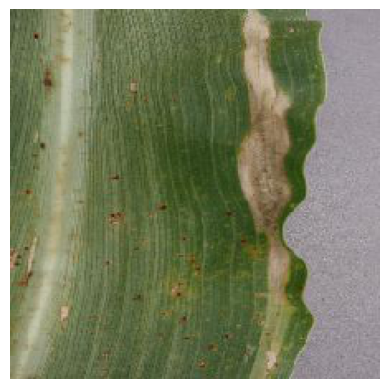

CNN MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions:
Class: Northern Leaf Blight, Confidence: 1.0


MOBILEV2 MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predictions:
Class: Northern Leaf Blight, Confidence: 0.9838311672210693


In [65]:
# Define a function to make readable predictions
def readable_prediction(image_path, m, categories):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocess the image as needed
    
    # Make predictions
    predictions = m.predict(img_array)
    
    # Print predictions in a readable form
    print('Predictions:')
    for pred in predictions:
        predicted_class_index = np.argmax(pred)
        confidence = np.max(pred)
        predicted_class_label = categories[predicted_class_index]
        print(f"Class: {predicted_class_label}, Confidence: {confidence}")

def get_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')        
    plt.show()

# The following is an image path for an image. It gives the confidence level of the prediction made for the image
image_path = 'Corn (Maize)/Val/Northern Leaf Blight/c0c7e666-4b2b-46f1-b315-274cfee65342___RS_NLB 4014_flipTB.JPG'
categories = ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

get_image(image_path)

print('CNN MODEL:')
readable_prediction(image_path, cnn_model, categories)
print('\n')
print('MOBILEV2 MODEL:')
readable_prediction(image_path, model, categories)
